<a href="https://colab.research.google.com/github/gvanzyll/ams-airbnb-price-pred/blob/master/Amsterdam_Airbnb_Price_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data & libraries. 

The data can be found [here](https://www.kaggle.com/erikbruin/airbnb-amsterdam?select=listings_details.csv).

In [99]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders
    !pip install pdpbox
    !pip install shap

In [100]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

In [2]:
# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My Drive/Airbnb Ams Data

/content/gdrive/My Drive/Airbnb Ams Data


In [4]:
!ls

calendar.csv  listings_details.csv  neighbourhoods.geojson
listings.csv  neighbourhoods.csv    reviews.csv


In [5]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# EDA

Starting by merging the two listings data sets into one large dataframe. 

In [113]:
df = pd.merge(pd.read_csv('listings.csv'), pd.read_csv('listings_details.csv'), on='id')

In [115]:
df.tail()

,id,name_x,host_id_x,host_name_x,neighbourhood_group,neighbourhood_x,latitude_x,longitude_x,room_type_x,price_x,minimum_nights_x,number_of_reviews_x,last_review_x,reviews_per_month_x,calculated_host_listings_count_x,availability_365_x,listing_url,scrape_id,last_scraped,name_y,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id_y,host_url,host_name_y,host_since,host_location,host_about,...,beds,bed_type,amenities,square_feet,price_y,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_y,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365_y,calendar_last_scraped,number_of_reviews_y,first_review,last_review_y,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count_y,reviews_per_month_y
20025,30576148,Family House City + free Parking+garden (160 m2),13399651,Marieke,NaN,Watergraafsmeer,52.345999,4.952145,Entire home/apt,340,7,0,NaN,NaN,1,11,https://www.airbnb.com/rooms/30576148,20181206172549,2018-12-06,Family House City + free Parking+garden (160 m2),Spacious (160m2) family house + FREE private p...,"Our house is a spacious family house, just ren...",Spacious (160m2) family house + FREE private p...,none,"Restaurants supermarkets, 5 Minutes inner inn...",NaN,Public transport just 3 min walk. Direct Conne...,You have access to our house all privately. Wi...,as much as possible before their stay. and ava...,- Only available for families (adults > 25 yea...,NaN,NaN,https://a0.muscache.com/im/pictures/53883e4d-f...,NaN,13399651,https://www.airbnb.com/users/show/13399651,Marieke,2014-03-22,"Amsterdam, North Holland, Netherlands",Ik ben Marieke. Woon in Amsterdam Centrum met ...,...,4.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",He...",NaN,$340.00,NaN,NaN,$500.00,$60.00,1,$0.00,7,12,today,t,11,11,11,11,2018-12-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,{Amsterdam},f,f,strict_14_with_grace_period,f,f,1,NaN
20026,30577727,Home Sweet Home in Indische Buurt,1595885,Evita,NaN,Oostelijk Havengebied - Indische Buurt,52.362412,4.932467,Entire home/apt,150,3,0,NaN,NaN,2,16,https://www.airbnb.com/rooms/30577727,20181206172549,2018-12-06,Home Sweet Home in Indische Buurt,My Home Sweet Home is a beautiful apartment th...,We have fluffy bedsheets and cozy lighning. Th...,My Home Sweet Home is a beautiful apartment th...,none,My Home Sweet Home is located in the beautiful...,NaN,My apartment is very well connected to public ...,NaN,We rent our Home Sweet Home during our holiday...,- It is a family neighbourhood! We don`t accep...,NaN,NaN,https://a0.muscache.com/im/pictures/78b2221b-d...,NaN,1595885,https://www.airbnb.com/users/show/1595885,Evita,2012-01-11,"Zurich, Zurich, Switzerland","Hy, my name is Evita, i`m from Zürich Switzerl...",...,3.0,Real Bed,"{TV,Wifi,Kitchen,Essentials,""Hair dryer"",Iron}",NaN,$150.00,NaN,NaN,$0.00,$25.00,1,$0.00,3,14,today,t,14,16,16,16,2018-12-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,{Amsterdam},f,f,flexible,f,f,2,NaN
20027,30578037,Amsterdam Cozy apartment nearby center,87866499,Tommaso,NaN,Oud-Oost,52.362431,4.926912,Entire home/apt,80,10,0,NaN,NaN,2,210,https://www.airbnb.com/rooms/30578037,20181206172549,2018-12-06,Amsterdam Cozy apartment nearby center,Lightful apartment with 1 room available in th...,NaN,Lightful apartment with 1 room available in th...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/363fac0e-6...,NaN,87866499,https://www.airbnb.com/users/show/87866499,Tommaso,2016-08-04,"Amsterdam, North Holland, Netherlands",NaN,...,1

111 columns! Right off the bat it looks like there are a few I'll need to get rid of. Better yet, I'll make a list of columns that I want to keep

In [8]:
columns = ['neighbourhood_x',
           'latitude_x',
           'longitude_x',
           'room_type_x',
           'price_x',
           'minimum_nights_x',
           'number_of_reviews_x',
           'host_since', 
           'host_is_superhost', 
           'host_total_listings_count', 
           'host_has_profile_pic', 
           'host_identity_verified', 
           'beds', 
           'bed_type',
           'cleaning_fee', 
           'guests_included', 
           'availability_365_y', 
           'review_scores_rating', 
           'instant_bookable', 
           'cancellation_policy'
           ]

In [9]:
df = df[columns]

'weekly_price', 'monthly_price', and 'security_deposit' are all LEAKY features. Maybe cleaning fee too? 

only looking at total score for now, but the individual rating categories could be interesting later!

In [10]:
df.shape

(20030, 20)

Null Values? 

In [11]:
df.isnull().sum()

neighbourhood_x                 0
latitude_x                      0
longitude_x                     0
room_type_x                     0
price_x                         0
minimum_nights_x                0
number_of_reviews_x             0
host_since                      4
host_is_superhost               4
host_total_listings_count       4
host_has_profile_pic            4
host_identity_verified          4
beds                            7
bed_type                        0
cleaning_fee                 3629
guests_included                 0
availability_365_y              0
review_scores_rating         2639
instant_bookable                0
cancellation_policy             0
dtype: int64

In [12]:
df.dropna(how='any', axis=0, inplace=True)

Outliers?

After taking a look at Airbnb and seeing some obvious incorrectly priced listings, I'm removing the 6 most expensive listings and the 3 cheapest.  

In [13]:
df = df.sort_values('price_x')
df = df.iloc[:-6, :]
df = df.iloc[3:, :]

In [14]:
df.head()

,neighbourhood_x,latitude_x,longitude_x,room_type_x,price_x,minimum_nights_x,number_of_reviews_x,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,beds,bed_type,cleaning_fee,guests_included,availability_365_y,review_scores_rating,instant_bookable,cancellation_policy
10970,Noord-West,52.405858,4.914031,Private room,23,3,52,2017-02-03,f,3.0,t,f,1.0,Real Bed,$15.00,1,12,90.0,t,moderate
11614,Noord-West,52.407425,4.913881,Private room,24,3,62,2017-02-03,f,3.0,t,f,1.0,Real Bed,$15.00,1,9,94.0,t,moderate
15118,Oostelijk Havengebied - Indische Buurt,52.362884,4.932089,Private room,25,1,10,2012-11-29,t,1.0,t,f,1.0,Real Bed,$15.00,1,0,96.0,t,flexible
14919,Bijlmer-Oost,52.319960,4.968869,Private room,25,1,76,2017-08-27,f,1.0,t,f,2.0,Real Bed,$10.00,1,352,86.0,t,flexible
9234,IJburg - Zeeburgereiland,52.356679,4.999393,Private room,26,3,1,2015-10-26,t,3.0,t,t,1.0,Real Bed,$45.00,1,0,100.0,f,strict_14_with_grace_period


In [15]:
df.shape

(14748, 20)

In [16]:
df.dtypes

neighbourhood_x               object
latitude_x                   float64
longitude_x                  float64
room_type_x                   object
price_x                        int64
minimum_nights_x               int64
number_of_reviews_x            int64
host_since                    object
host_is_superhost             object
host_total_listings_count    float64
host_has_profile_pic          object
host_identity_verified        object
beds                         float64
bed_type                      object
cleaning_fee                  object
guests_included                int64
availability_365_y             int64
review_scores_rating         float64
instant_bookable              object
cancellation_policy           object
dtype: object

# Data Clean

Change 'cleaning_fee' from str to int

In [17]:
df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '').astype(float)

Convert datetime column into # of days since the host started (as an integer), using the date that the data was collected 

In [18]:
df['host_since'] = pd.to_datetime(df['host_since'])

In [19]:
df['date_data_collected'] = '2018-12-06'

In [20]:
df['date_data_collected'] = pd.to_datetime(df['date_data_collected'])

In [21]:
df['host_since_num'] = df['date_data_collected'] - df['host_since']

In [22]:
df['host_since_num']

10970    671 days
11614    671 days
15118   2198 days
14919    466 days
9234    1137 days
           ...   
3328    1494 days
9795    2479 days
9695     808 days
18362   2544 days
11857   2789 days
Name: host_since_num, Length: 14748, dtype: timedelta64[ns]

In [23]:
df['host_since_num'] = df['host_since_num'].dt.days.astype('int16')

In [24]:
df.drop(columns=['date_data_collected', 'host_since'], inplace=True)

In [25]:
df.head()

,neighbourhood_x,latitude_x,longitude_x,room_type_x,price_x,minimum_nights_x,number_of_reviews_x,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,beds,bed_type,cleaning_fee,guests_included,availability_365_y,review_scores_rating,instant_bookable,cancellation_policy,host_since_num
10970,Noord-West,52.405858,4.914031,Private room,23,3,52,f,3.0,t,f,1.0,Real Bed,15.0,1,12,90.0,t,moderate,671
11614,Noord-West,52.407425,4.913881,Private room,24,3,62,f,3.0,t,f,1.0,Real Bed,15.0,1,9,94.0,t,moderate,671
15118,Oostelijk Havengebied - Indische Buurt,52.362884,4.932089,Private room,25,1,10,t,1.0,t,f,1.0,Real Bed,15.0,1,0,96.0,t,flexible,2198
14919,Bijlmer-Oost,52.319960,4.968869,Private room,25,1,76,f,1.0,t,f,2.0,Real Bed,10.0,1,352,86.0,t,flexible,466
9234,IJburg - Zeeburgereiland,52.356679,4.999393,Private room,26,3,1,t,3.0,t,t,1.0,Real Bed,45.0,1,0,100.0,f,strict_14_with_grace_period,1137


So far, so good! Now to dig a little deeper on some of those columns to see if any further feature engineering is needed. 

In [26]:
df['neighbourhood_x'].nunique()

22

Not too high-cardinality, but not sure we need this column since we have latitiude and longitude... But it would be nice to see when presenting predictions. Going to drop it for now. 

In [27]:
df.drop(columns='neighbourhood_x', inplace=True)

But first, let's drop the x's and y's from the column names since I didn't do that in the merge. 

In [28]:
col_names = ['latitude',
           'longitude',
           'room_type',
           'price',
           'minimum_nights',
           'number_of_reviews',
           'host_is_superhost', 
           'host_total_listings_count', 
           'host_has_profile_pic', 
           'host_identity_verified', 
           'beds', 
           'bed_type',
           'cleaning_fee', 
           'guests_included', 
           'availability_365', 
           'review_scores_rating', 
           'instant_bookable', 
           'cancellation_policy',
           'host_since_num'
           ]

In [29]:
df.columns = col_names

# Change True/False columns to Binary

There are some T/F columns that should be changed to Boolean! Start by making sure they only have two values

In [30]:
df['instant_bookable'].nunique()

2

In [31]:
df['host_has_profile_pic'].nunique()

2

In [32]:
df['host_identity_verified'].nunique()

2

In [33]:
df['host_is_superhost'].nunique()

2

In [34]:
df['instant_bookable'] = df['instant_bookable'].apply(lambda value: 1 if value == 't' else 0)

In [35]:
df['host_has_profile_pic'] = df['host_has_profile_pic'].apply(lambda value: 1 if value == 't' else 0)

In [36]:
df['host_identity_verified'] = df['host_identity_verified'].apply(lambda value: 1 if value == 't' else 0)

In [37]:
df['host_identity_verified'] = df['host_identity_verified'].apply(lambda value: 1 if value == 't' else 0)

Checking a few more HCC's

In [38]:
df['bed_type'].nunique()

5

In [39]:
df['cancellation_policy'].nunique()

4

In [40]:
df['room_type'].nunique()

3

Nice! Hit the jackpot with this data set 😀

Already time for some modeling?

# Split

In [41]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [44]:
X_train.shape, X_val.shape, X_test.shape

((8848, 18), (2950, 18), (2950, 18))

In [45]:
y_train.shape, y_val.shape, y_test.shape

((8848,), (2950,), (2950,))

# Baseline

In [46]:
y_pred_baseline = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred_baseline)

print('Mean Price:',y_train.mean())
print('Baseline MAE:',baseline_mae )

Mean Price: 150.81600361663652
Baseline MAE: 57.774315831123346


Good news- the bar is low! The baseline is off by about 38% on average!

# Regression

In [47]:
ohe = OneHotEncoder(use_cat_names=True)

ohe.fit(X_train) 

OneHotEncoder(cols=['room_type', 'host_is_superhost', 'bed_type',
                    'cancellation_policy'],
              use_cat_names=True)

In [48]:
XT_train = ohe.transform(X_train)
XT_val = ohe.transform(X_val)
XT_test = ohe.transform(X_test)
XT = ohe.transform(X)

In [49]:
XT_train.shape, XT_val.shape, XT_test.shape

((8848, 27), (2950, 27), (2950, 27))

In [50]:
XT_train.head()

,latitude,longitude,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,minimum_nights,number_of_reviews,host_is_superhost_f,host_is_superhost_t,host_total_listings_count,host_has_profile_pic,host_identity_verified,beds,bed_type_Real Bed,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Airbed,cleaning_fee,guests_included,availability_365,review_scores_rating,instant_bookable,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_flexible,cancellation_policy_super_strict_60,host_since_num
3799,52.361638,4.861408,1,0,0,4,10,1,0,1.0,1,0,1.0,1,0,0,0,35.0,1,0,92.0,0,1,0,0,0,1312
13435,52.356800,4.897758,1,0,0,2,23,1,0,2.0,1,0,2.0,1,0,0,0,50.0,2,0,84.0,0,0,1,0,0,1254
12374,52.368642,4.884503,1,0,0,3,9,1,0,4.0,1,0,6.0,1,0,0,0,60.0,1,69,84.0,0,0,0,1,0,1549
1918,52.351980,4.902122,1,0,0,3,35,1,0,1.0,1,0,2.0,1,0,0,0,30.0,2,362,95.0,0,1,0,0,0,2358
14240,52.381355,4.855570,1,0,0,2,23,0,1,1.0,1,0,1.0,1,0,0,0,25.0,1,0,99.0,1,1,0,0,0,1737


# Linear

In [51]:
model_lr = LinearRegression()

In [52]:
model_lr.fit(XT_train, y_train)

LinearRegression()

In [53]:
training_mae_lr = mean_absolute_error(y_train, model_lr.predict(XT_train))
val_mae_lr = mean_absolute_error(y_val, model_lr.predict(XT_val))

print('Linear Training MAE:', training_mae_lr)
print('Linear Validation MAE:', val_mae_lr)

Linear Training MAE: 44.72041026306755
Linear Validation MAE: 43.75722789774523


In [54]:
print("Linear Training R-Squared:", r2_score(y_train,model_lr.predict(XT_train)) )
print("Linear Validation R-Squared:", r2_score(y_val,model_lr.predict(XT_val)))

Linear Training R-Squared: 0.35691462103603844
Linear Validation R-Squared: 0.3432481363241422


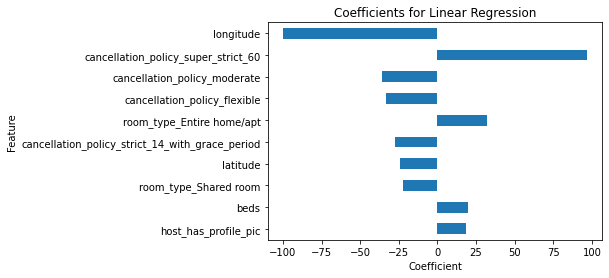

In [55]:
coefficients = model_lr.coef_
features = ohe.get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')

plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Linear Regression');

# Ridge

In [56]:
model_r = Ridge(alpha=31.0) # starting with 1 as default

In [57]:
model_r.fit(XT_train, y_train)

Ridge(alpha=31.0)

In [58]:
training_mae_r = mean_absolute_error(y_train, model_r.predict(XT_train))
val_mae_r = mean_absolute_error(y_val, model_r.predict(XT_val))

print('Ridge Training MAE:', training_mae_r)
print('Ridge Validation MAE:', val_mae_r)

Ridge Training MAE: 44.72632652994795
Ridge Validation MAE: 43.64860863562291


In [59]:
print("Ridge Training R-Squared:", r2_score(y_train,model_r.predict(XT_train)) )
print("Ridge Validation R-Squared:", r2_score(y_val,model_r.predict(XT_val)))

Ridge Training R-Squared: 0.3546775902102811
Ridge Validation R-Squared: 0.34533987368228736


Ridge Hyperparameter Tuning - different alphas didn't seem to do anything! Unfortunate. 

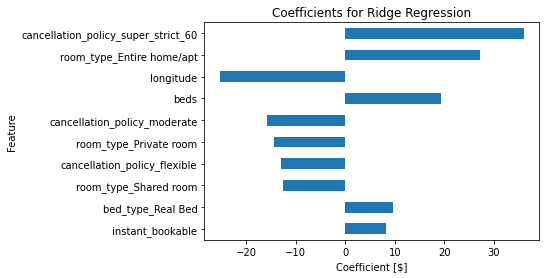

In [60]:
coefficients = model_r.coef_
features = ohe.get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')

plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');


Cheeky Viz

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


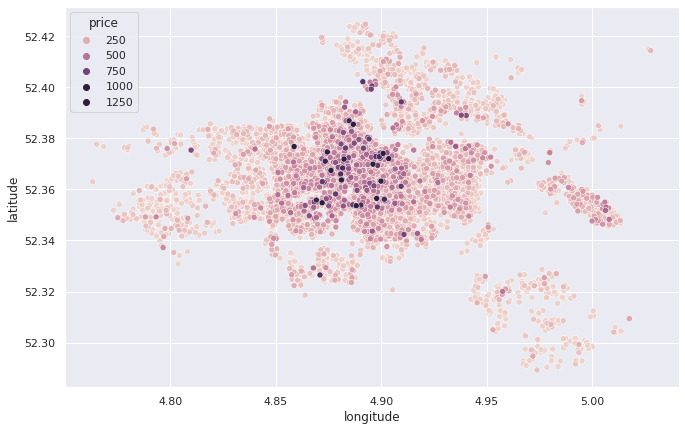

In [61]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11,7)})
sns.scatterplot('longitude', 'latitude', hue_norm=(100,1000), hue='price', data=df);

# Random Forest

In [62]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(random_state=42, 
                           n_jobs=-1)
    )

model_rf.fit(X_train, y_train);

In [63]:
training_mae_rf = mean_absolute_error(y_train, model_rf.predict(X_train))
val_mae_rf = mean_absolute_error(y_val, model_rf.predict(X_val))

print('Random Forest Training MAE:', training_mae_rf)
print('Random Forest Validation MAE:', val_mae_rf)

Random Forest Training MAE: 15.081683996383362
Random Forest Validation MAE: 39.28148474576271


In [64]:
print("Random Forest Training R-Squared:", r2_score(y_train,model_rf.predict(X_train)) )
print("Random Forest Validation R-Squared:", r2_score(y_val,model_rf.predict(X_val)))

Random Forest Training R-Squared: 0.9221106084705832
Random Forest Validation R-Squared: 0.43668356372426476


Yikes! This does not generalize well... Let's see if we can tune some hyperparameters. 

Randomized Search - Use full X & y

In [65]:
X.head()

,latitude,longitude,room_type,minimum_nights,number_of_reviews,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,beds,bed_type,cleaning_fee,guests_included,availability_365,review_scores_rating,instant_bookable,cancellation_policy,host_since_num
10970,52.405858,4.914031,Private room,3,52,f,3.0,1,0,1.0,Real Bed,15.0,1,12,90.0,1,moderate,671
11614,52.407425,4.913881,Private room,3,62,f,3.0,1,0,1.0,Real Bed,15.0,1,9,94.0,1,moderate,671
15118,52.362884,4.932089,Private room,1,10,t,1.0,1,0,1.0,Real Bed,15.0,1,0,96.0,1,flexible,2198
14919,52.319960,4.968869,Private room,1,76,f,1.0,1,0,2.0,Real Bed,10.0,1,352,86.0,1,flexible,466
9234,52.356679,4.999393,Private room,3,1,t,3.0,1,0,1.0,Real Bed,45.0,1,0,100.0,0,strict_14_with_grace_period,1137


In [66]:
param_grid = {
    'randomforestregressor__max_depth': range(5, 40, 5),
    'randomforestregressor__n_estimators': range(25, 125, 25),
    'randomforestregressor__max_samples': np.arange(.1, 1, .1)
}

model_rfrs = RandomizedSearchCV(
    model_rf,
    param_distributions = param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter = 50
)

model_rfrs.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['room_type',
                                                                   'host_is_superhost',
                                                                   'bed_type',
                                                                   'cancellation_policy'],
                                                             mapping=[{'col': 'room_type',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': Entire home/apt    1
Private room       2
Shared room        3
NaN               -2
dtype: int64},
                                                                      {'col': 'host_is_superhost',
                                                                       'data_type': dtype('O'),
          

In [67]:
model_rfrs.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_samples': 0.4,
 'randomforestregressor__n_estimators': 75}

In [68]:
model_rfrs.best_score_

-21.589844438285382

In [69]:
model_rf2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(random_state=42,
                          max_depth = 15,
                          n_estimators=75, 
                          max_samples=.4,
                          n_jobs=-1)
    )

model_rf2.fit(XT_train, y_train);

In [70]:
training_mae_rf2 = mean_absolute_error(y_train, model_rf2.predict(XT_train))
val_mae_rf2 = mean_absolute_error(y_val, model_rf2.predict(XT_val))

print('Random Forest 2 Training MAE:', training_mae_rf2)
print('Random Forest 2 Validation MAE:', val_mae_rf2)

Random Forest 2 Training MAE: 29.400448137123778
Random Forest 2 Validation MAE: 39.48582766813116


In [71]:
print("Random Forest 2 Training R-Squared:", r2_score(y_train,model_rf2.predict(XT_train)) )
print("Random Forest 2 Validation R-Squared:", r2_score(y_val,model_rf2.predict(XT_val)))

Random Forest 2 Training R-Squared: 0.7305941725168288
Random Forest 2 Validation R-Squared: 0.44048419797049665


In [72]:
model_rf3 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(random_state=42,
                          max_depth = 10,
                          n_estimators=50, 
                          max_samples=.4,
                          n_jobs=-1)
    )

model_rf3.fit(XT_train, y_train);

In [73]:
training_mae_rf3 = mean_absolute_error(y_train, model_rf3.predict(XT_train))
val_mae_rf3 = mean_absolute_error(y_val, model_rf3.predict(XT_val))

print('Random Forest 3 Training MAE:', training_mae_rf3)
print('Random Forest 3 Validation MAE:', val_mae_rf3)

Random Forest 3 Training MAE: 34.58204213798619
Random Forest 3 Validation MAE: 39.80800129220239


In [74]:
print("Random Forest 3 Training R-Squared:", r2_score(y_train,model_rf3.predict(XT_train)) )
print("Random Forest 3 Validation R-Squared:", r2_score(y_val,model_rf3.predict(XT_val)))

Random Forest 3 Training R-Squared: 0.6483009080908851
Random Forest 3 Validation R-Squared: 0.43009995041435733


Progress!!!

# XGBoost

In [75]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBRegressor(random_state=42, n_jobs=-1) # learning_rate=0.1, 0.01, 02
)

model_xgb.fit(X_train, y_train)

[16:05:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['room_type', 'host_is_superhost',
                                      'bed_type', 'cancellation_policy'],
                                mapping=[{'col': 'room_type',
                                          'data_type': dtype('O'),
                                          'mapping': Entire home/apt    1
Private room       2
Shared room        3
NaN               -2
dtype: int64},
                                         {'col': 'host_is_superhost',
                                          'data_type': dtype('O'),
                                          'mapping': f      1
t      2
NaN   -2
dtype: int64},
                                         {'col': 'bed_type',
                                          'data_type': dtype('O'),
                                          'mapping': Real Bed         1
Futon            2
Pull-out Sofa    3
Airbed           4
NaN             -2
dtype: int64},
               

In [76]:
training_mae_xgb = mean_absolute_error(y_train, model_xgb.predict(X_train))
val_mae_xgb = mean_absolute_error(y_val, model_xgb.predict(X_val))
test_mae_xgb = mean_absolute_error(y_test, model_xgb.predict(X_test))

print('XGB Training MAE:', training_mae_xgb)
print('XGB Validation MAE:', val_mae_xgb)
print('XGB Test MAE:', test_mae_xgb)

XGB Training MAE: 36.998728997668564
XGB Validation MAE: 37.97731815144167
XGB Test MAE: 38.74468302839893


In [77]:
print("XGB Training R-Squared:", r2_score(y_train,model_xgb.predict(X_train)) )
print("XGB Validation R-Squared:", r2_score(y_val,model_xgb.predict(X_val)))
print("XGB Test R-Squared:", r2_score(y_test,model_xgb.predict(X_test)))

XGB Training R-Squared: 0.5624129571278879
XGB Validation R-Squared: 0.4708247800838574
XGB Test R-Squared: 0.47385895758392993


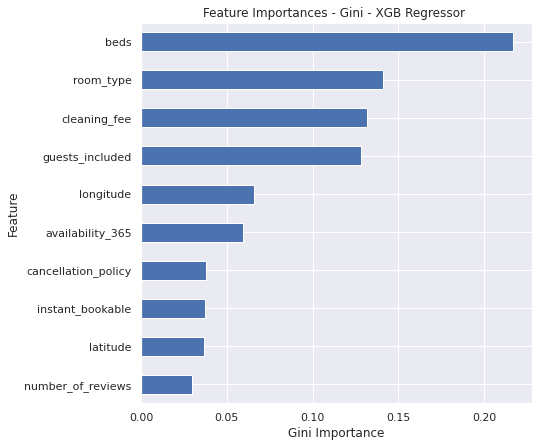

In [78]:
sns.set(rc={'figure.figsize':(7,7)})

importances = model_xgb.named_steps['xgbregressor'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances - Gini - XGB Regressor ');


In [118]:
ord = OrdinalEncoder()

ord.fit(X_train) 

X_ord_train = ohe.transform(X_train)
X_ord_val = ohe.transform(X_val)
X_ord_test = ohe.transform(X_test)
X_ord = ohe.transform(X)


model_xgb_shap = XGBRegressor(random_state=42, n_jobs=-1) 
model_xgb_shap.fit(X_ord_train, y_train)

[16:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=-1, random_state=42)

In [124]:
sample_row = X_ord_val.head(1)
explainer = shap.TreeExplainer(model_xgb_shap)  # does not like pipelines
shap_value = explainer.shap_values(sample_row)

In [125]:
shap.initjs() #initialization of java script.
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_value,
    features = sample_row)

In [110]:
shap.initjs() #initialization of java script.
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_value,
    features = sample_row
)

In [112]:
df['price'].head(25)

KeyError: ignored

In [79]:
param_grid_xgb = {
    'xgbregressor__max_depth': range(2, 20, 2),
    'xgbregressor__n_estimators': range(25, 125, 25),
    'xgbregressor__max_samples': np.arange(.1, 1, .1),
    'xgbregressor__learning_rate': np.arange(.01, .11, .01) #try lower learning rate

}

model_xgbrs = RandomizedSearchCV(
    model_xgb,
    param_distributions = param_grid_xgb,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter = 50
)

model_xgbrs.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[16:14:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['room_type',
                                                                   'host_is_superhost',
                                                                   'bed_type',
                                                                   'cancellation_policy'],
                                                             mapping=[{'col': 'room_type',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': Entire home/apt    1
Private room       2
Shared room        3
NaN               -2
dtype: int64},
                                                                      {'col': 'host_is_superhost',
                                                                       'data_type': dtype('O'),
          

In [80]:
model_xgbrs.best_params_

{'xgbregressor__learning_rate': 0.060000000000000005,
 'xgbregressor__max_depth': 8,
 'xgbregressor__max_samples': 0.6,
 'xgbregressor__n_estimators': 25}

In [81]:
model_xgb2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBRegressor(random_state=42, 
                 learning_rate=.03,
                 max_depth=2,
                 max_samples=.2,
                 n_estimators=50,
                 n_jobs=-1) # learning_rate=0.1, 0.01, 02
)

model_xgb2.fit(X_train, y_train)

[16:14:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['room_type', 'host_is_superhost',
                                      'bed_type', 'cancellation_policy'],
                                mapping=[{'col': 'room_type',
                                          'data_type': dtype('O'),
                                          'mapping': Entire home/apt    1
Private room       2
Shared room        3
NaN               -2
dtype: int64},
                                         {'col': 'host_is_superhost',
                                          'data_type': dtype('O'),
                                          'mapping': f      1
t      2
NaN   -2
dtype: int64},
                                         {'col': 'bed_type',
                                          'data_type':...
                                          'mapping': Real Bed         1
Futon            2
Pull-out Sofa    3
Airbed           4
NaN             -2
dtype: int64},
                        

In [82]:
training_mae_xgb2 = mean_absolute_error(y_train, model_xgb2.predict(X_train))
val_mae_xgb2 = mean_absolute_error(y_val, model_xgb2.predict(X_val))

print('XGB2 Training MAE:', training_mae_xgb2)
print('XGB2 Validation MAE:', val_mae_xgb2)

XGB2 Training MAE: 47.388556543353666
XGB2 Validation MAE: 44.679342524641655


# Classification!

# Shifting gears a bit - creating 3 price categories:



*   Low (under 100)
*   Medium (100-175)
*   High (over 175)

Do we have roughly even numbers? 



In [83]:
lmh_list = []
for price in df['price']:
  if price < 100:
   lmh_list.append('low')
  elif price <= 175:
    lmh_list.append('med')
  else:
    lmh_list.append('high') 

In [84]:
df['low_med_high'] = lmh_list

In [85]:
y.value_counts()

150    872
100    778
120    726
125    493
200    470
      ... 
339      1
323      1
307      1
251      1
24       1
Name: price, Length: 383, dtype: int64

In [86]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,host_total_listings_count,host_has_profile_pic,host_identity_verified,beds,cleaning_fee,guests_included,availability_365,review_scores_rating,instant_bookable,host_since_num
count,14748.000000,14748.000000,14748.000000,14748.000000,14748.000000,14748.000000,14748.000000,14748.0,14748.000000,14748.000000,14748.000000,14748.000000,14748.000000,14748.000000,14748.000000
mean,52.365487,4.888730,149.657513,3.068077,24.347369,5.465419,0.999254,0.0,1.874898,38.409344,1.551939,59.288175,94.886086,0.231082,1476.187890
std,0.015623,0.034840,88.165603,9.652987,42.934908,26.663775,0.027301,0.0,1.390037,21.880709,0.961637,102.202810,6.491763,0.421539,659.079085
min,52.289274,4.763264,23.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,20.000000,0.000000,16.000000
25%,52.355429,4.863827,99.000000,2.000000,5.000000,1.000000,1.000000,0.0,1.000000,25.000000,1.000000,0.000000,93.000000,0.000000,975.000000
50%,52.364833,4.885978,129.000000,2.000000,11.000000,1.000000,1.000000,0.0,1.000000,35.000000,1.000000,4.000000,97.000000,0.000000,1530.000000
75%,52.375178,4.907498,175.000000,3.000000,25.000000,1.000000,1.000000,0.0,2.000000,50.000000,2.000000,69.000000,100.000000,0.000000,1967.250000
max,52.424713,5.027689,1254.000000,1001.000000,695.000000,698.000000,1.000000,0.0,32.000000,300.000000,16.000000,365.000000,100.000000,1.000000,3725.000000


In [87]:
df.head()

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,beds,bed_type,cleaning_fee,guests_included,availability_365,review_scores_rating,instant_bookable,cancellation_policy,host_since_num,low_med_high
10970,52.405858,4.914031,Private room,23,3,52,f,3.0,1,0,1.0,Real Bed,15.0,1,12,90.0,1,moderate,671,low
11614,52.407425,4.913881,Private room,24,3,62,f,3.0,1,0,1.0,Real Bed,15.0,1,9,94.0,1,moderate,671,low
15118,52.362884,4.932089,Private room,25,1,10,t,1.0,1,0,1.0,Real Bed,15.0,1,0,96.0,1,flexible,2198,low
14919,52.319960,4.968869,Private room,25,1,76,f,1.0,1,0,2.0,Real Bed,10.0,1,352,86.0,1,flexible,466,low
9234,52.356679,4.999393,Private room,26,3,1,t,3.0,1,0,1.0,Real Bed,45.0,1,0,100.0,0,strict_14_with_grace_period,1137,low


In [88]:
df['low_med_high'].value_counts()

med     7377
low     3858
high    3513
Name: low_med_high, dtype: int64

In [89]:
df.drop(columns='price', inplace=True)

# Logistic Regression

In [90]:
from sklearn.linear_model import LogisticRegression

In [91]:
target = 'low_med_high'

X_cl = df.drop(columns=target)
y_cl = df[target]

Split

In [92]:
X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, test_size=0.2, random_state=42)
X_cl_train, X_cl_val, y_cl_train, y_cl_val = train_test_split(X_cl_train, y_cl_train, test_size=0.25, random_state=42)


In [93]:
baseline_acc = y_cl_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.49615732368896925


Logistic Classification

In [94]:
model_logr = make_pipeline(
    OneHotEncoder(use_cat_names=True), # Encode categorical values
    SimpleImputer(strategy='mean'), # fills Nan values with column mean
    StandardScaler(), # re-scales all features  (mean = 0, std=1)
    LogisticRegression()
)

model_logr.fit(X_cl_train, y_cl_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['room_type', 'host_is_superhost',
                                     'bed_type', 'cancellation_policy'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [95]:
print('Training Accuracy:', model_logr.score(X_cl_train, y_cl_train))
print('Validation Accuracy:', model_logr.score(X_cl_val, y_cl_val))

Training Accuracy: 0.6194620253164557
Validation Accuracy: 0.6237288135593221


Random Forest Classifier

In [96]:
model_rf_cl = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, 
                           n_jobs=-1)
    )

model_rf_cl.fit(X_cl_train, y_cl_train);

In [97]:
print('Random Forest Classifier Training Accuracy:', model_rf_cl.score(X_cl_train, y_cl_train))
print('Random Forest Classifier Validation Accuracy:', model_rf_cl.score(X_cl_val, y_cl_val))

Random Forest Classifier Training Accuracy: 1.0
Random Forest Classifier Validation Accuracy: 0.6623728813559322


Introducing some bias & tuning hyperparameters

In [98]:
param_grid_rf_cl = {
    'randomforestclassifier__max_depth': range(5, 40, 5),
    'randomforestclassifier__n_estimators': range(25, 125, 25),
    'randomforestclassifier__max_samples': np.arange(.1, 1, .1)
}

model_rfrs_cl = RandomizedSearchCV(
    model_rf_cl,
    param_distributions = param_grid_rf_cl,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter = 50
)

model_rfrs_cl.fit(X_cl, y_cl)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: ignored

In [ ]:
model_rfrs_cl.best_params_

In [ ]:
model_rf_cl2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42,
                          max_depth = 15,
                          n_estimators=100, 
                          max_samples=.8,
                          n_jobs=-1)
    )

model_rf_cl2.fit(X_cl_train, y_cl_train);

In [ ]:
print('Random Forest Classifier Training Accuracy:', model_rf_cl2.score(X_cl_train, y_cl_train))
print('Random Forest Classifier Validation Accuracy:', model_rf_cl2.score(X_cl_val, y_cl_val))
print('Random Forest Classifier Test Accuracy:', model_rf_cl2.score(X_cl_test, y_cl_test))

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})

importances = model_rf_cl2.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances - Gini - RF Classifier');


XGB Classifier

In [ ]:
model_xgb_cl = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42, n_jobs=-1) 
)

model_xgb_cl.fit(X_cl_train, y_cl_train)

In [ ]:
print('XGB Classifier Training Accuracy:', model_xgb_cl.score(X_cl_train, y_cl_train))
print('XGB Classifier Validation Accuracy:', model_xgb_cl.score(X_cl_val, y_cl_val))

In [ ]:
param_grid_xgb_cl = {
    'xgbclassifier__max_depth': range(2, 20, 2),
    'xgbclassifier__n_estimators': range(25, 125, 25),
    'xgbclassifier__max_samples': np.arange(.1, 1, .1),
    'xgbclassifier__learning_rate': np.arange(.01, .11, .01) 

}

model_xgbrs_cl = RandomizedSearchCV(
    model_xgb_cl,
    param_distributions = param_grid_xgb_cl,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter = 50
)

model_xgbrs_cl.fit(X_cl, y_cl)

In [ ]:
model_xgbrs_cl.best_params_

In [ ]:
model_xgb_cl2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42,
                  learning_rate=.08,
                  max_depth=6,
                  n_estimators=75, 
                  max_samples=.2,
                  n_jobs=-1) 
)

model_xgb_cl2.fit(X_cl_train, y_cl_train)

In [ ]:
print('XGB Classifier Training Accuracy:', model_xgb_cl2.score(X_cl_train, y_cl_train))
print('XGB Classifier Validation Accuracy:', model_xgb_cl2.score(X_cl_val, y_cl_val))